In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
from torch.nn import Softplus #smooth relu
import torch.nn as nn
import torch.nn.functional as F
from utils import generate_polynomial_data
import numpy as np
import torch
import torch.optim as optim
from torch.nn import MSELoss
import pickle, copy
from tqdm import tqdm

from model import Net, check_loss_landscape

import matplotlib.pyplot as plt

In [19]:
torch.manual_seed(0)
suffix = "3"

n = 300
d = 5000
generate_data = False
usepickle = True

coeffs = -1+2*np.random.rand(d, 1)
xvals = -1+2*np.random.rand(n)
fileend = ".pickle" if usepickle else ".npy"

if generate_data:
    print("Generating Data...")
    X, Y = generate_polynomial_data(coeffs, xvals)
    with open("./datasets/X%s%s" %(("pickle_" if usepickle else ""), suffix)+fileend, "wb") as f:
        if usepickle:
            pickle.dump(X, f)
        else:
            np.save(f, X)
    with open("./datasets/Y%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "wb") as f:
        if usepickle:
            pickle.dump(Y, f)
        else:
            np.save(f, Y)
    with open("./datasets/coeffs%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "wb") as f:
        if usepickle:
            pickle.dump(coeffs, f)
        else:
            np.save(f, coeffs)
    
else:
    with open("./datasets/X%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "rb") as f:
        if usepickle:
            X = pickle.load(f)
        else:
            X = np.load(f)
    with open("./datasets/Y%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "rb") as f:
        if usepickle:
            Y = pickle.load(f)
        else:
            Y = np.load(f)
    with open("./datasets/coeffs%s%s" %(("pickle_" if usepickle else ""),suffix) + fileend, "rb") as f:
        if usepickle:
            coeffs = pickle.load(f)
        else:
            coeffs = np.load(f)

Running on GPU


  0%|          | 0/2000 [00:00<?, ?it/s]

Running on GPU


  2%|▏         | 36/2000 [00:00<00:05, 359.72it/s]

Epoch 1 iteration 2000 loss: 1.73


  2%|▏         | 41/2000 [00:00<00:04, 403.74it/s]

Epoch 2 iteration 2000 loss: 1.73


  2%|▏         | 41/2000 [00:00<00:04, 401.50it/s]

Epoch 3 iteration 2000 loss: 1.72


  2%|▏         | 41/2000 [00:00<00:04, 401.43it/s]

Epoch 4 iteration 2000 loss: 1.72


  2%|▏         | 40/2000 [00:00<00:04, 398.25it/s]

Epoch 5 iteration 2000 loss: 1.69


  2%|▏         | 41/2000 [00:00<00:04, 400.02it/s]

Epoch 6 iteration 2000 loss: 1.51


  2%|▏         | 36/2000 [00:00<00:05, 359.73it/s]

Epoch 7 iteration 2000 loss: 0.18


  2%|▏         | 30/2000 [00:00<00:06, 295.84it/s]

Epoch 8 iteration 2000 loss: 0.06


  1%|▏         | 27/2000 [00:00<00:07, 266.06it/s]

Epoch 9 iteration 2000 loss: 0.05


  2%|▏         | 36/2000 [00:00<00:05, 358.94it/s]

Epoch 10 iteration 2000 loss: 0.05


  2%|▏         | 40/2000 [00:00<00:04, 398.78it/s]

Epoch 11 iteration 2000 loss: 0.04


  2%|▏         | 41/2000 [00:00<00:04, 405.55it/s]

Epoch 12 iteration 2000 loss: 0.04


  2%|▏         | 41/2000 [00:00<00:04, 401.40it/s]

Epoch 13 iteration 2000 loss: 0.03


  2%|▏         | 43/2000 [00:00<00:04, 426.92it/s]

Epoch 14 iteration 2000 loss: 0.03


  2%|▏         | 41/2000 [00:00<00:04, 399.97it/s]

Epoch 15 iteration 2000 loss: 0.02


  2%|▏         | 35/2000 [00:00<00:05, 343.46it/s]

Epoch 16 iteration 2000 loss: 0.02


  2%|▏         | 39/2000 [00:00<00:05, 388.36it/s]

Epoch 17 iteration 2000 loss: 0.02


  2%|▏         | 39/2000 [00:00<00:05, 380.69it/s]

Epoch 18 iteration 2000 loss: 0.01


  2%|▏         | 44/2000 [00:00<00:04, 430.49it/s]

Epoch 19 iteration 2000 loss: 0.01


100%|██████████| 2000/2000 [00:04<00:00, 419.35it/s]


Epoch 20 iteration 2000 loss: 0.01
[1.72851744556427, 1.7262043681740762, 1.7231687685847283, 1.715903261601925, 1.689072456419468, 1.5077092576175928, 0.18082507244870066, 0.0623973631169647, 0.05492405565455556, 0.04803256053104997, 0.04182822812348604, 0.03623597198352218, 0.031192358641885222, 0.02665089706145227, 0.022579247557558118, 0.018956803851760923, 0.015770363937132062, 0.013007067050319164, 0.010649605181999505, 0.00867262186226435]


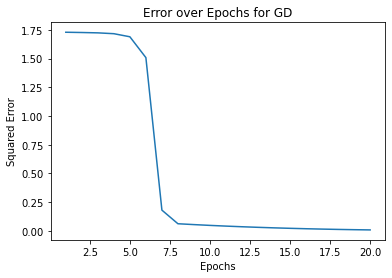

In [4]:
torch.manual_seed(0)

sgd = False
train = True

if sgd:
    model_path = "./models/model_sgd_%s.pt"%suffix
    net = Net(d, epochs = 50)
else:
    model_path = "./models/model_sgd_%s_O100_params.pt"%suffix
    net = Net(d, epochs = 20)
    
if train:
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print("Running on GPU")
    net.to(device)
    if sgd:
        net.train_sgd(X, Y, 100000, lr = 1e-2)
    else:
        net.train_gd(X, Y, 2000, lr = 1e-3)
    torch.save(net.state_dict(), model_path)

Overall loss: tensor(0.0016, grad_fn=<MseLossBackward>)
-1.1929947137832642 -1.2289554403602838
-0.08187440782785416 -0.13516816398732573
-0.8887646198272705 -0.920158456466009
0.19159135222434998 0.13974400340630586
0.24176660180091858 0.2411133016681187
[-1.2289554403602838, -0.13516816398732573, -0.920158456466009, 0.13974400340630586, 0.2411133016681187]


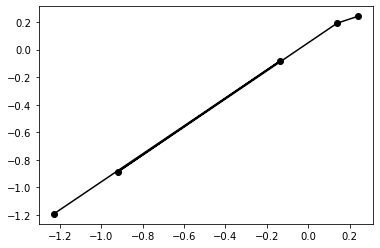

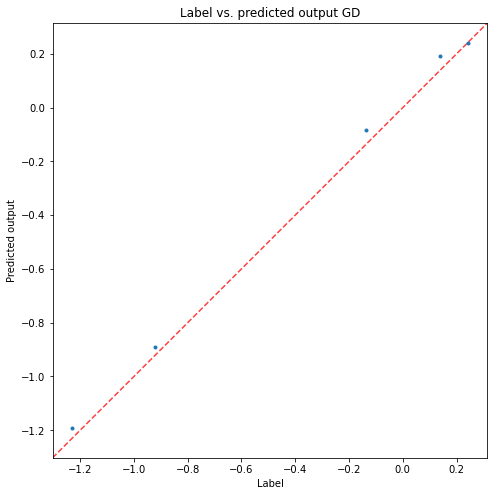

In [5]:
check_loss_landscape(model_path, X, Y, sgd=False)

In [8]:
from pyhessian import hessian

In [11]:
model = Net(d, categorical=False).cuda()
model_state_dict_path = "./models/model_sgd_%s_O100_params.pt"%suffix
model.load_state_dict(torch.load(model_state_dict_path))

criterion = torch.nn.MSELoss(reduction="sum")
inputs = torch.from_numpy(X).to(device).float()
targets = torch.from_numpy(Y).to(device).float()

hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=True)

In [12]:
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues()

In [14]:
print("The top Hessian eigenvalue of this model is %.4f"%top_eigenvalues[-1])
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2)
print("The top two eigenvalues of this model are: %.4f %.4f"% (top_eigenvalues[-1],top_eigenvalues[-2]))

The top Hessian eigenvalue of this model is 1997.6628
The top two eigenvalues of this model are: 10.9887 1997.6625


In [15]:
def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

Text(0.5, 1.0, 'Loss landscape perturbed based on top Hessian eigenvector')

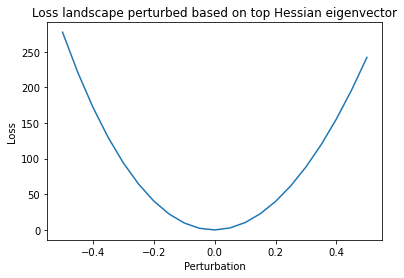

In [21]:
# lambda is a small scalar that we use to perturb the model parameters along the eigenvectors 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = copy.deepcopy(model)
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams:
    model_perb = get_params(model, model_perb, top_eigenvector[0], lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on top Hessian eigenvector')

Text(0.5, 1.0, 'Loss landscape perturbed based on a random direction')

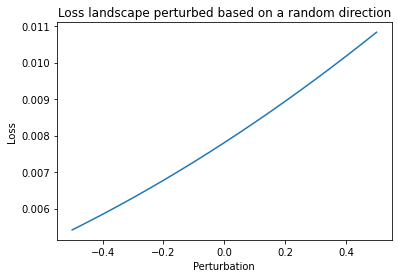

In [22]:
from pyhessian.utils import normalization

# generate random vector to do the loss plot

v = [torch.randn_like(p) for p in model.parameters()]
v = normalization(v)


# used to perturb your model 
lams = np.linspace(-0.5, 0.5, 21).astype(np.float32)

loss_list = []

# create a copy of the model
model_perb = copy.deepcopy(model)
model_perb.eval()
model_perb = model_perb.cuda()

for lam in lams: 
    model_perb = get_params(model, model_perb, v, lam)
    loss_list.append(criterion(model_perb(inputs), targets).item())

plt.plot(lams, loss_list)
plt.ylabel('Loss')
plt.xlabel('Perturbation')
plt.title('Loss landscape perturbed based on a random direction')

# old

In [ ]:
net = Net(d, epochs = 20)

In [ ]:
device = next(net.parameters()).device

In [ ]:
X_cuda = torch.from_numpy(X).to(device)
Y_cuda = torch.from_numpy(Y).to(device)

In [ ]:
net.train_gd(X, Y, T=2000, lr=1e-03)

In [ ]:
model_path = "./models/model_%s.pt"%suffix
torch.save(net.state_dict(), model_path)

In [ ]:
check_loss_landscape(model_path, X, Y)